# RADS Notebook

[Jupyter Notebooks](http://jupyter.org/) allow you to combine text, code, output from the code and figures into a single document.
They can be useful for interactive data exploration or for saving notes and plots in a session.
Text cells are formatted using Markdown which allows for lists:

* item
* more items

equations:

<!--- Kepler's third law -->
$$\frac{P^2}{a^3} = \frac{4\pi^2}{G(M+m)} \approx \frac{4\pi^2}{G M}$$

tables:

| A             | Simple        | Table |
| ------------- |:-------------:| -----:|
| 1             | 2             | 3     |
| 4             | 5             | 6     |

and pretty much anything else you can put on a web page.

In the code cell below we import the Python modules needed for the rest of the notebook.

In [1]:
from datetime import datetime
import shlex
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4

The next code cell sets the parameters for our Radar Altimeter Database System
([RADS](https://github.com/remkos/rads)) run and defines the RADS command as we
would enter it in the shell.

In [2]:
sat = "sa"
t0 = 20170101
t1 = 20170111
# Hawaii
lon0 = -165
lon1 = -150
lat0 = 15
lat1 = 26
# US East Coast
#lon0 = -98
#lon1 = -50
#lat0 = 20
#lat1 = 50
fnc = sat + ".nc"
var = "time,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007"
rads_command = ("rads2nc --sat={} --ymd={},{} --region={},{},{},{} --var={} "
        "--output={}").format(sat, t0, t1, lon0, lon1, lat0, lat1, var, fnc)
# the following line is useful to show the value for rads_command in an
# interactive environment, but not for a script
rads_command

'rads2nc --sat=sa --ymd=20170101,20170111 --region=-165,-150,15,26 --var=time,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007 --output=sa.nc'

The next cell actually executes the `rads_command`.  The `stdout` is redirected to `/dev/null`.  If the RADS command
exits with an error, an exception will be raised and in a script this will cause the script to exit.

In [3]:
subprocess.check_call(shlex.split(rads_command), stdout=subprocess.DEVNULL)

Now read the netCDF file and use its data to create a `pandas` `DataFrame`.  A `DataFrame` can be thought of as
a well defined spreadsheet.  It is a tabular data structure with each column containing one of the variables that we
requested from RADS.  In this case each row is the time of a 1 Hz sample.

In [4]:
nc = netCDF4.Dataset(fnc, "r")
keys = list(nc.variables.keys())
# time = nc.variables["time"][:]
time_index = datetime(1985, 1, 1) + pd.to_timedelta(nc.variables["time"][:], unit="s")
df = pd.DataFrame(index=time_index)
for key in keys[1:]:
    df[key] = nc.variables[key][:]
nc.close()

The following 3 cells contain methods that you wouldn't normally use in a script, but they are useful
when working interactively.

In [5]:
df.head()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
2017-01-01 04:57:30.265751,25.960473,-159.832158,-0.0404,2.145,5.09,-0.0021,-0.0005
2017-01-01 04:57:31.301160,25.899287,-159.847799,-0.0075,2.107,5.34,-0.0022,-0.0005
2017-01-01 04:57:32.336567,25.838101,-159.863427,-0.0500,2.169,4.95,-0.0022,-0.0005
2017-01-01 04:57:33.371974,25.776913,-159.879044,-0.0260,2.078,4.88,-0.0022,-0.0005
2017-01-01 04:57:34.407382,25.715724,-159.894650,-0.0607,2.165,4.59,-0.0022,-0.0005


In [6]:
df.tail(3)

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
2017-01-10 05:17:20.071299,25.095008,-164.961532,0.1476,1.780,4.92,-0.0019,-0.0005
2017-01-10 05:17:21.107235,25.033775,-164.977019,0.1503,1.713,4.72,-0.0020,-0.0005
2017-01-10 05:17:22.143170,24.972541,-164.992495,0.1367,1.798,4.45,-0.0020,-0.0005


In [7]:
df.describe()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.00000
mean,20.517574,-162.989504,0.089739,2.100399,5.990769,-0.002227,-0.00075
std,3.173635,1.340418,0.086712,0.458520,1.918321,0.000901,0.00029
min,15.004455,-164.996010,-0.110200,1.434000,1.160000,-0.005000,-0.00140
25%,17.908969,-164.065946,0.024750,1.806250,4.625000,-0.002700,-0.00100
50%,20.329048,-163.217260,0.086600,1.961000,6.010000,-0.002000,-0.00060
75%,23.262722,-162.060643,0.152875,2.243000,7.080000,-0.001500,-0.00050
max,25.963137,-159.832158,0.318800,3.805000,12.960000,-0.001100,-0.00050


There are two equivalent ways to access an entire column of a `DataFrame`

    df["col_name"]
    df.col_name

In scripts I recommend using the first form.  The second form is convenient for interactive use.  In
addition to being shorter, Jupyter and IPython have tab completion when using this form.  There are some
[restrictions](http://pandas-docs.github.io/pandas-docs-travis/indexing.html#attribute-access)
with the short form which is known as attibute access.  With this form the index element can't contain
spaces, start with a digit, or conflict with an existing method name (e.g. min).  None of these restrictions
apply when using the longer form.
For the rest of this Notebook, I will include the long form as a
comment above the short form.

Now let's apply some editing criteria.  We want to discard all rows where $swh \geq 3.0$ or $wind \geq 10.0$.
The tests below are expressed in term of the data to keep.
You will see that count has been reduced indicating discarded data and max $swh$ and $wind$ show that our limits have been applied.

In [8]:
# df = df[(df["swh"] < 3.0) & (df["wind_speed"] < 10.0)]
df = df[(df.swh < 3.0) & (df.wind_speed < 10.0)]
df.describe()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,20.159806,-162.986505,0.086460,1.993360,5.635818,-0.002277,-0.000760
std,3.059901,1.343109,0.087667,0.298222,1.493617,0.000916,0.000296
min,15.004455,-164.996010,-0.110200,1.434000,1.160000,-0.005000,-0.001400
25%,17.669267,-164.028229,0.021700,1.792000,4.445000,-0.002800,-0.001100
50%,19.899999,-163.246800,0.081400,1.935000,5.810000,-0.002100,-0.000600
75%,22.525807,-162.147443,0.150800,2.150000,6.780000,-0.001500,-0.000500
max,25.963137,-159.832158,0.318800,2.983000,9.660000,-0.001200,-0.000500


In [9]:
df.head()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
2017-01-01 04:57:30.265751,25.960473,-159.832158,-0.0404,2.145,5.09,-0.0021,-0.0005
2017-01-01 04:57:31.301160,25.899287,-159.847799,-0.0075,2.107,5.34,-0.0022,-0.0005
2017-01-01 04:57:32.336567,25.838101,-159.863427,-0.0500,2.169,4.95,-0.0022,-0.0005
2017-01-01 04:57:33.371974,25.776913,-159.879044,-0.0260,2.078,4.88,-0.0022,-0.0005
2017-01-01 04:57:34.407382,25.715724,-159.894650,-0.0607,2.165,4.59,-0.0022,-0.0005


Next we'll create a new column for SLA using the iono_ira2007 correction instead of iono_gim.

In [10]:
# df["sla_iri2007"] = df["sla"] + df["iono_gim"] - df["iono_iri2007"]
df["sla_iri2007"] = df.sla + df.iono_gim - df.iono_iri2007
df.head()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007,sla_iri2007
2017-01-01 04:57:30.265751,25.960473,-159.832158,-0.0404,2.145,5.09,-0.0021,-0.0005,-0.0420
2017-01-01 04:57:31.301160,25.899287,-159.847799,-0.0075,2.107,5.34,-0.0022,-0.0005,-0.0092
2017-01-01 04:57:32.336567,25.838101,-159.863427,-0.0500,2.169,4.95,-0.0022,-0.0005,-0.0517
2017-01-01 04:57:33.371974,25.776913,-159.879044,-0.0260,2.078,4.88,-0.0022,-0.0005,-0.0277
2017-01-01 04:57:34.407382,25.715724,-159.894650,-0.0607,2.165,4.59,-0.0022,-0.0005,-0.0624


RADS outputs SLA in m.  We want to plot SLA in cm.  Below is an inplace conversion for SLA from m to cm.

In [11]:
# df["sla"] *= 100.0
df.sla *= 100.0
df.head()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007,sla_iri2007
2017-01-01 04:57:30.265751,25.960473,-159.832158,-4.04,2.145,5.09,-0.0021,-0.0005,-0.0420
2017-01-01 04:57:31.301160,25.899287,-159.847799,-0.75,2.107,5.34,-0.0022,-0.0005,-0.0092
2017-01-01 04:57:32.336567,25.838101,-159.863427,-5.00,2.169,4.95,-0.0022,-0.0005,-0.0517
2017-01-01 04:57:33.371974,25.776913,-159.879044,-2.60,2.078,4.88,-0.0022,-0.0005,-0.0277
2017-01-01 04:57:34.407382,25.715724,-159.894650,-6.07,2.165,4.59,-0.0022,-0.0005,-0.0624


Now plot a time series subset for SLA.  `df["2017-01-01T04:58:00":"2017-01-01T05:00:00"]` creates a 2 minute subset
of the `DataFrame` and passes the subset to `plot`.  Since we didn't assign this subset back to `df`, we still have
the full 10 day time series in `df`.

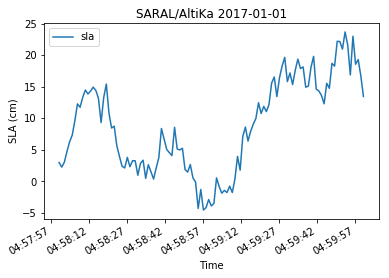

In [12]:
# subset for Hawaii
ax = df["2017-01-01T04:58:00":"2017-01-01T05:00:00"].plot(y="sla", title="SARAL/AltiKa 2017-01-01")
# subset for US East Coast
#ax = df["2017-01-01T09:22:00":"2017-01-01T09:24:00"].plot(y="sla", title="SARAL/AltiKa 2017-01-01")
ax.set_xlabel("Time")
ax.set_ylabel("SLA (cm)")
plt.show()    # if %matplotlib inline is used this is not needed in jupyter

Next plot data locations on a map.

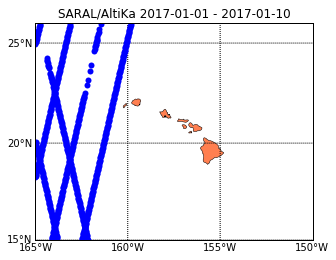

In [13]:
m = Basemap(resolution="i", projection="merc", llcrnrlat=lat0, urcrnrlat=lat1, llcrnrlon=lon0,
        urcrnrlon=lon1)
m.drawmapboundary()
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color="coral")
# labels=[left, right, top, bottom]    True/False or 1/0
m.drawparallels(np.arange(15, 26, 5), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-165, -149, 5), labels=[0, 0, 0, 1])
# don't name Basemap object map becase the following x, y = map() will cause confusion
# convert lon, lat to map projection coordinates
x, y = m(df.lon.values, df.lat.values)
m.plot(x, y, "bo", markeredgewidth=0)    # "bo" is a blue circle
plt.title("SARAL/AltiKa 2017-01-01 - 2017-01-10")
plt.show()

When working in Jupyter or IPython (but not in a regular python script), you can specify a code cell to be Bash
instead of Python.  This can be useful if you want to enter a series of Generic Mapping Tools ([GMT](http://gmt.soest.hawaii.edu/projects/gmt)) commands in your Notebook.

In [14]:
%%bash
# %%sh, %%script csh, %%perl are also valid
echo "everything in this cell is run with bash"
for x in 1 2 3
do
    echo "$x"
done
gmt --version

everything in this cell is run with bash
1
2
3
5.4.3


Working with text files in `pandas` is also easy.

In [15]:
fasc = fnc.replace("nc", "asc")
rads_command = rads_command.replace("nc", "asc")
rads_command

'rads2asc --sat=sa --ymd=20170101,20170111 --region=-165,-150,15,26 --var=time,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007 --output=sa.asc'

In [16]:
#subprocess.check_call(shlex.split(rads_command), stdout=subprocess.DEVNULL)
# ... names=["time", "lat", "lon",... "iono_iri2007"]
df = pd.read_table(fasc, names=var.split(","), delim_whitespace=True, comment="#")
df["time"] = datetime(1985, 1, 1) + pd.to_timedelta(df["time"], unit="s")
df = df.set_index("time")
df.head()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
time,,,,,,,
2017-01-01 04:57:30.265751,25.960473,-159.832158,-0.0404,2.145,5.09,-0.0021,-0.0005
2017-01-01 04:57:31.301160,25.899287,-159.847799,-0.0075,2.107,5.34,-0.0022,-0.0005
2017-01-01 04:57:32.336567,25.838101,-159.863427,-0.0500,2.169,4.95,-0.0022,-0.0005
2017-01-01 04:57:33.371974,25.776913,-159.879044,-0.0260,2.078,4.88,-0.0022,-0.0005
2017-01-01 04:57:34.407382,25.715724,-159.894650,-0.0607,2.165,4.59,-0.0022,-0.0005


In [17]:
df.describe()

,lat,lon,sla,swh,wind_speed,iono_gim,iono_iri2007
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.00000
mean,20.517574,-162.989504,0.089739,2.100399,5.990769,-0.002227,-0.00075
std,3.173635,1.340418,0.086712,0.458520,1.918321,0.000901,0.00029
min,15.004455,-164.996010,-0.110200,1.434000,1.160000,-0.005000,-0.00140
25%,17.908969,-164.065946,0.024750,1.806250,4.625000,-0.002700,-0.00100
50%,20.329048,-163.217260,0.086600,1.961000,6.010000,-0.002000,-0.00060
75%,23.262722,-162.060643,0.152875,2.243000,7.080000,-0.001500,-0.00050
max,25.963137,-159.832158,0.318800,3.805000,12.960000,-0.001100,-0.00050


A Jupyter Notebook is not just a snapshot of a Python session.  You can modify the code in any of the cells
and rerun the code to update the output.  For instance click in the second code cell and replace the
region parameters with:

    lon0 = -98
    lon1 = -50
    lat0 = 20
    lat1 = 50

Then in the Cell menu at the top of the page, select "Run All" and the cells will be rerun with your new parameters.

For more in depth information on these topics see:

A YouTube video with a good introduction to creating your own [Jupyter Notebooks](https://www.youtube.com/watch?v=HW29067qVWk).

[Pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/10min.html)

[Pandas Visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html)

[Basemap](http://matplotlib.org/basemap/users/examples.html)

[Matplotlib](http://matplotlib.org/1.5.1/users/pyplot_tutorial.html) is the lower level library that Pandas Visualizations and MPL Basemap are built on.